# Setup

In [1]:
DATA_VERSION = "2025-06-02"
# DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-06-04.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES_FROM_TRAINING = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.2
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies_from_training", sorted(EXCLUDE_POLITICAL_BODIES_FROM_TRAINING))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)

mlflow.sklearn.autolog()

Starting run: amusing-flea-555


2025/06/06 10:48:13 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-06-04.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-06-02.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-02.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53479,55411,5060,2025-05-28,2025-09-18,Verordnungsänderungen aufgrund der Übernahme u...,Die Verordnung (EU) 2024/1717 zur Revision des...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/umfaztmk,"[foreign_policy, migration, security]","[{'created_at': 2025-03-19 13:43:22, 'name': '...",...,Staatssekretariat für Migration,ch,47005,fedlex,manual,fedlex,VERORDNUNG (EU) 2024/1717 DES EUROPÄISCHEN PAR...,2025/5060/55411/1CPiqNKj4QBK8tT5w7SGSb.pdf,application/pdf,4dd82e826398db696ba59a0583f55a62eef3196c
53482,55414,5060,2025-05-28,2025-09-18,Verordnungsänderungen aufgrund der Übernahme u...,Die Verordnung (EU) 2024/1717 zur Revision des...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/umfaztmk,"[foreign_policy, migration, security]","[{'

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55411,4dd82e826398db696ba59a0583f55a62eef3196c,False,24,0.0,0.0,2.0,2.0,0.707071
55414,3cb50a5e32bb8c525274ee718220e1c5a6ebd895,False,2,0.0,0.0,2.0,2.0,0.707098
55417,b1ac63c73715f799358378e0ac5a8b8cf0615c22,False,2,0.0,0.0,2.0,2.0,0.707098


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55423,"[0.01773596927523613, -0.02248694933950901, -0..."
55424,"[0.017001070082187653, -0.02505420707166195, -..."
55425,"[0.0036743315868079662, -0.010835361666977406,..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1268 documents (5.4%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 5292 rows (23.7%) were lost due to missing features. Remaining rows: 17017. 15 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024   Total
political_body                                                                                                                    
ag                 0     0     0     0     0    63    17    52    27    13    62     3    59    75    59    57     5     3   495.0
ai  

## Split

In [13]:
df_input_train, df_input_test = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.26% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.97% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.16% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.18% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.16% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

In [14]:
print(
    "Excluding documents from these political bodies from training:",
    df_input_train[df_input_train["political_body"].isin(EXCLUDE_POLITICAL_BODIES_FROM_TRAINING)]["political_body"]
    .astype(str)
    .value_counts(),
    sep="\n",
)
df_input_train = df_input_train[~df_input_train["political_body"].isin(EXCLUDE_POLITICAL_BODIES_FROM_TRAINING)]

Excluding documents from these political bodies from training:
political_body
sz    69
bl     4
Name: count, dtype: int64


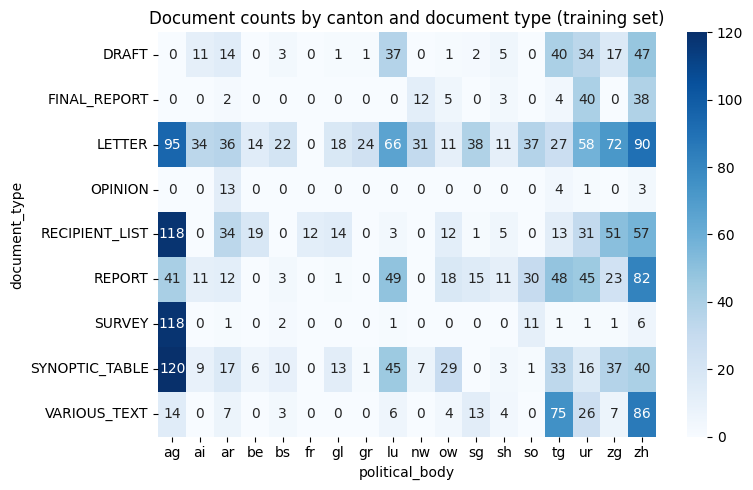

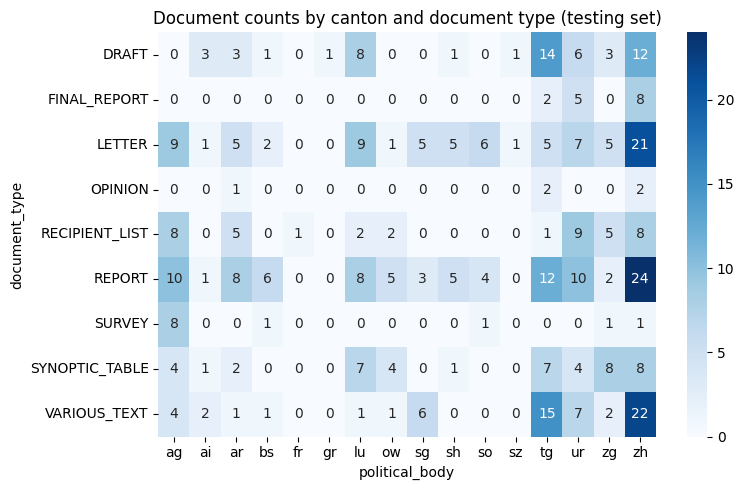

In [15]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test, "testing")

In [16]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    11654
manual     1652
rule        903
Name: count, dtype: int64

document_type
LETTER            3048
DRAFT             2904
REPORT            2394
RECIPIENT_LIST    2019
FINAL_REPORT      1728
OPINION            804
VARIOUS_TEXT       646
SYNOPTIC_TABLE     501
SURVEY             165
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [17]:
display(df_input_test["document_type_label_source"].value_counts(dropna=False))
display(df_input_test["document_type"].value_counts(dropna=False))

document_type_label_source
manual    414
fedlex      0
rule        0
Name: count, dtype: int64

document_type
REPORT            98
LETTER            82
VARIOUS_TEXT      62
DRAFT             53
SYNOPTIC_TABLE    46
RECIPIENT_LIST    41
FINAL_REPORT      15
SURVEY            12
OPINION            5
DECISION           0
LINK               0
PRESS_RELEASE      0
RESPONSE_FORM      0
Name: count, dtype: int64

In [18]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

414

# Data exploration

## Data representation

In [19]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
fedlex                      DRAFT             2691
                            LETTER            2364
                            REPORT            2005
                            RECIPIENT_LIST    1649
                            FINAL_REPORT      1624
                            OPINION            783
                            VARIOUS_TEXT       401
                            SYNOPTIC_TABLE     114
                            SURVEY              23
                            DECISION             0
                            LINK                 0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
rule                        LETTER             358
                            RECIPIENT_LIST     208
                            SYNOPTIC_TABLE     203
                            SURVEY              93
                            FINAL_REPORT        41
                            DECISION   

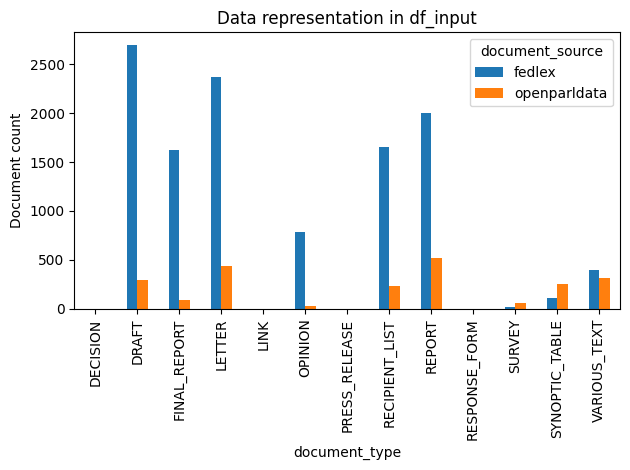

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2691,299
FINAL_REPORT,1624,95
LETTER,2364,438
LINK,0,0
OPINION,783,26
PRESS_RELEASE,0,0
RECIPIENT_LIST,1649,237
REPORT,2005,518


In [20]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [21]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001115,0.000000
FINAL_REPORT,0.003695,0.042105
LETTER,0.985195,0.995434
OPINION,0.747126,0.692308
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.012968,0.048263
SURVEY,0.000000,0.048387
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014963,0.009646


### Keyword-like features

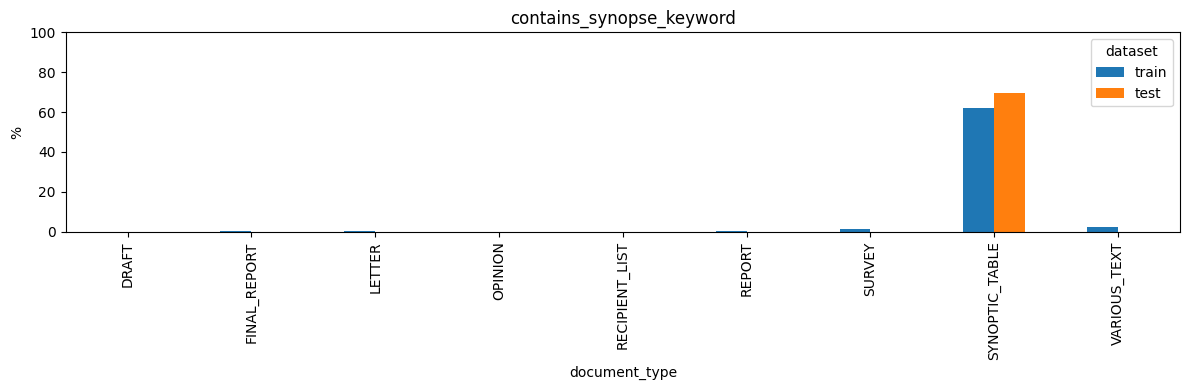

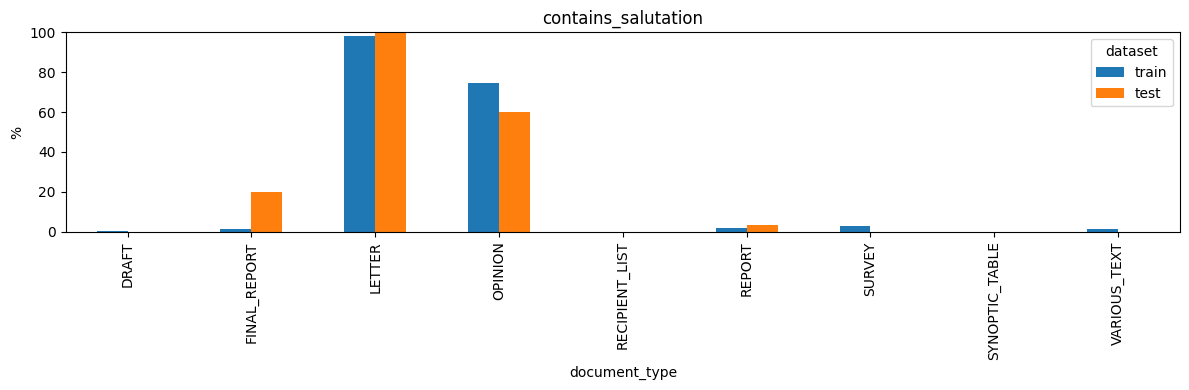

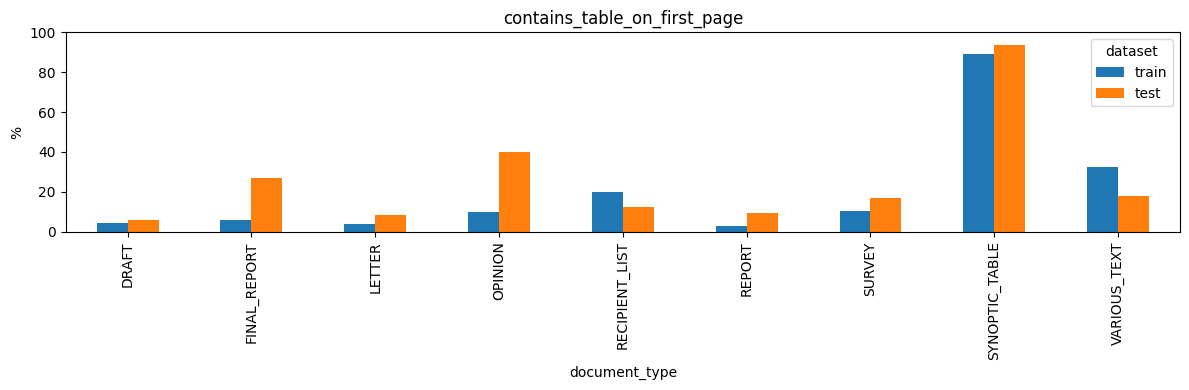

In [22]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_table_on_first_page")

In [23]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

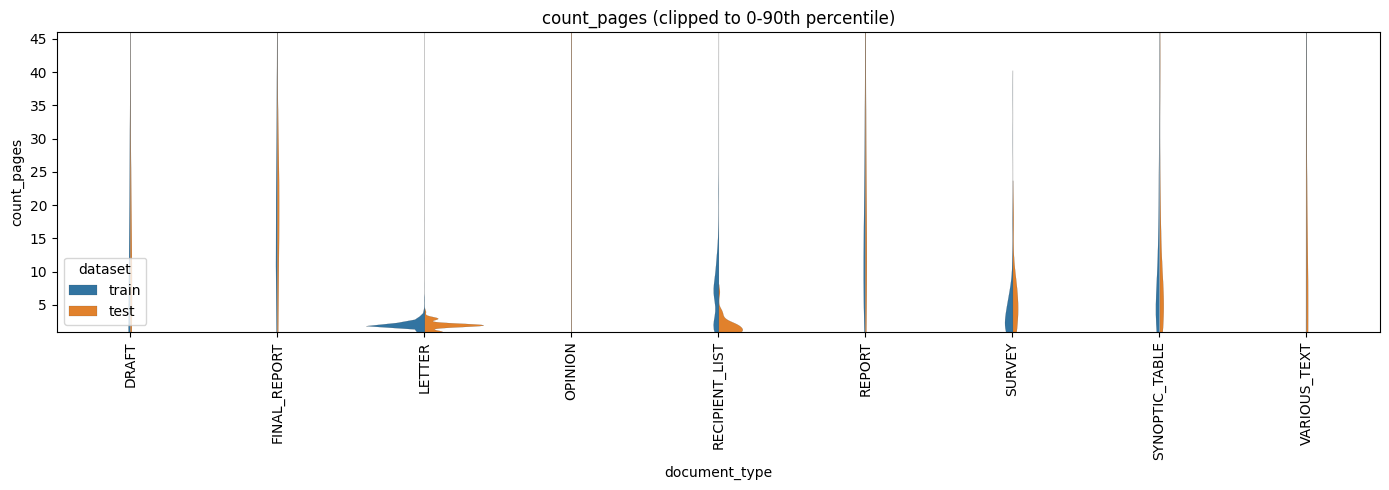

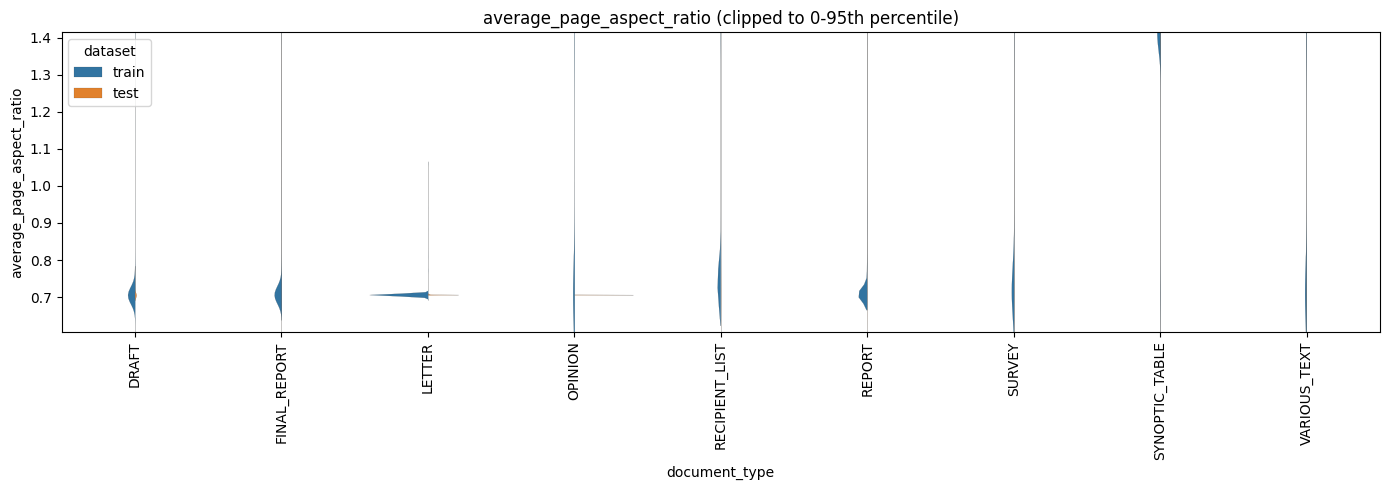

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset              test       train       test       train
document_type                                               
DRAFT           14.660377   13.661846  26.551795   45.806201
FINAL_REPORT    18.800000   27.403935  13.518242   45.110429
LETTER           1.975610    2.166995   0.628060    1.419310
OPINION         53.400000  364.554726  57.304450  730.510874
RECIPIENT_LIST   1.878049    7.198118   1.208204    5.399444
REPORT          23.857143   24.547619  24.244034   29.522053
SURVEY           5.833333    4.321212   4.725816    4.595846
SYNOPTIC_TABLE   8.608696   10.762475   8.817856   13.660361
VARIOUS_TEXT    12.822581   21.199690  25.801591  155.118695

In [26]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.708493  0.729490  0.013294  0.113237
FINAL_REPORT    1.026217  0.726789  0.308452  0.102940
LETTER          0.707149  0.707853  0.000489  0.014791
OPINION         0.707034  0.827395  0.000122  0.250516
RECIPIENT_LIST  0.724297  0.769612  0.110503  0.180483
REPORT          0.800340  0.722615  0.187390  0.084803
SURVEY          0.771437  0.769194  0.203307  0.178922
SYNOPTIC_TABLE  1.388698  1.369617  0.113644  0.168009
VARIOUS_TEXT    0.785262  0.875708  0.223962  0.300060

### Tables

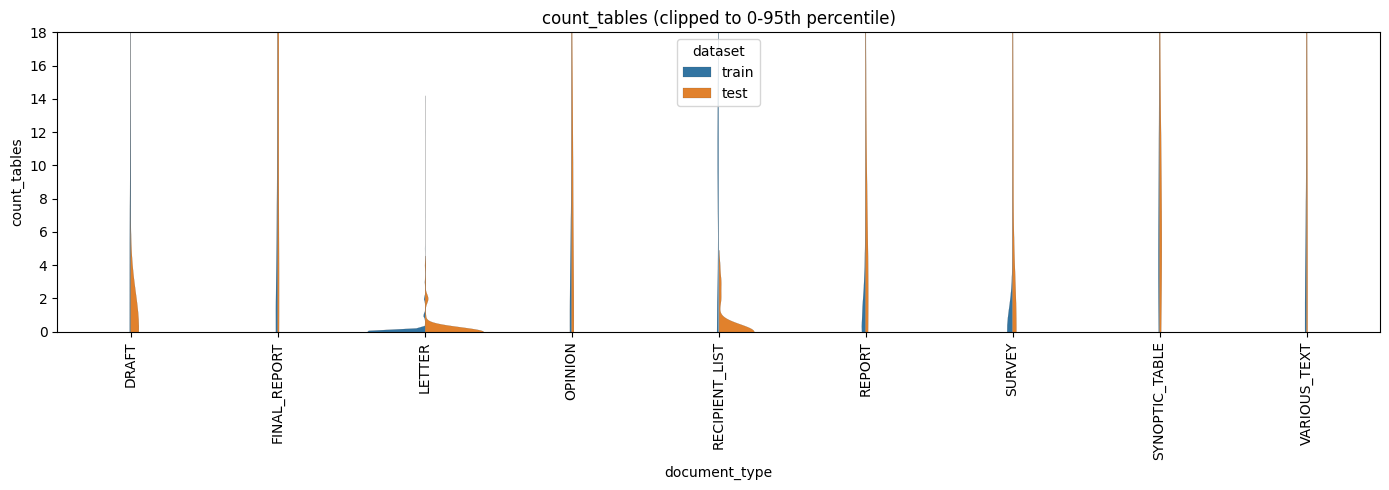

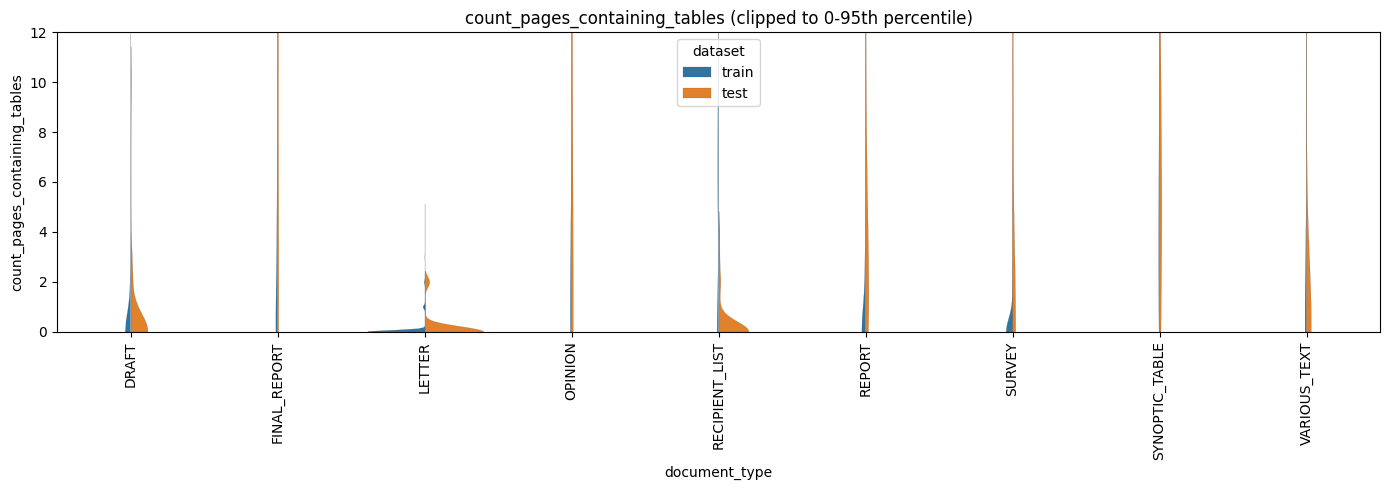

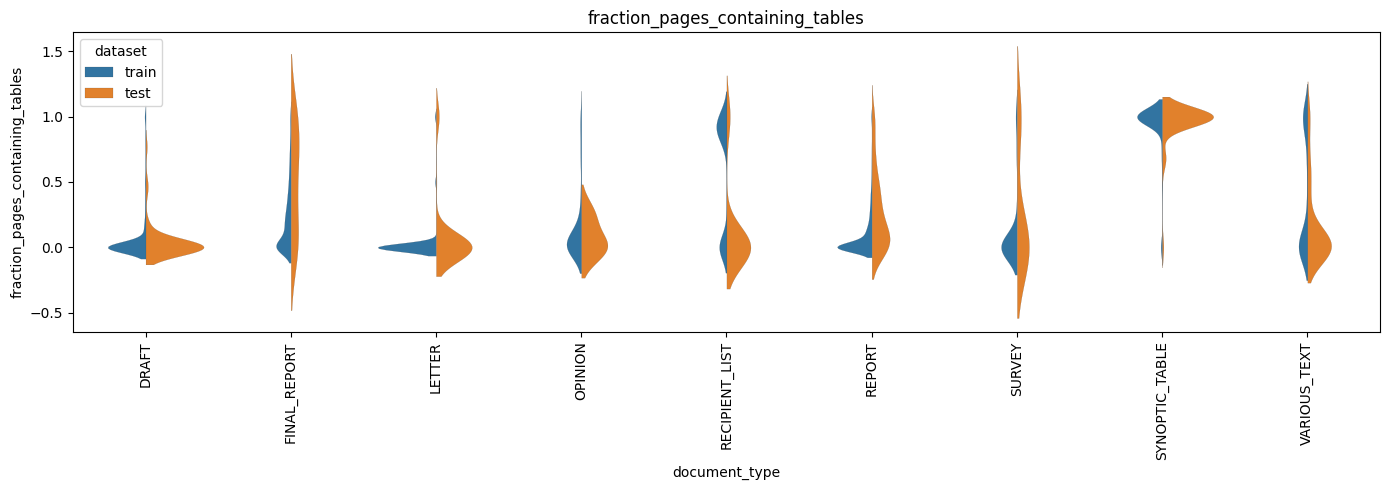

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_tables")

### Images

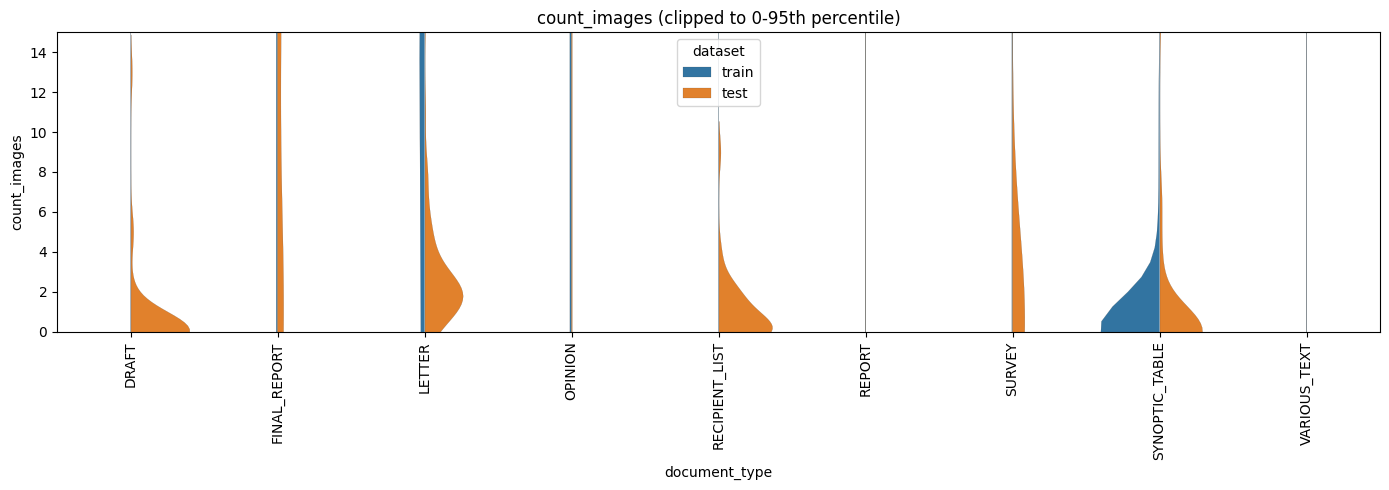

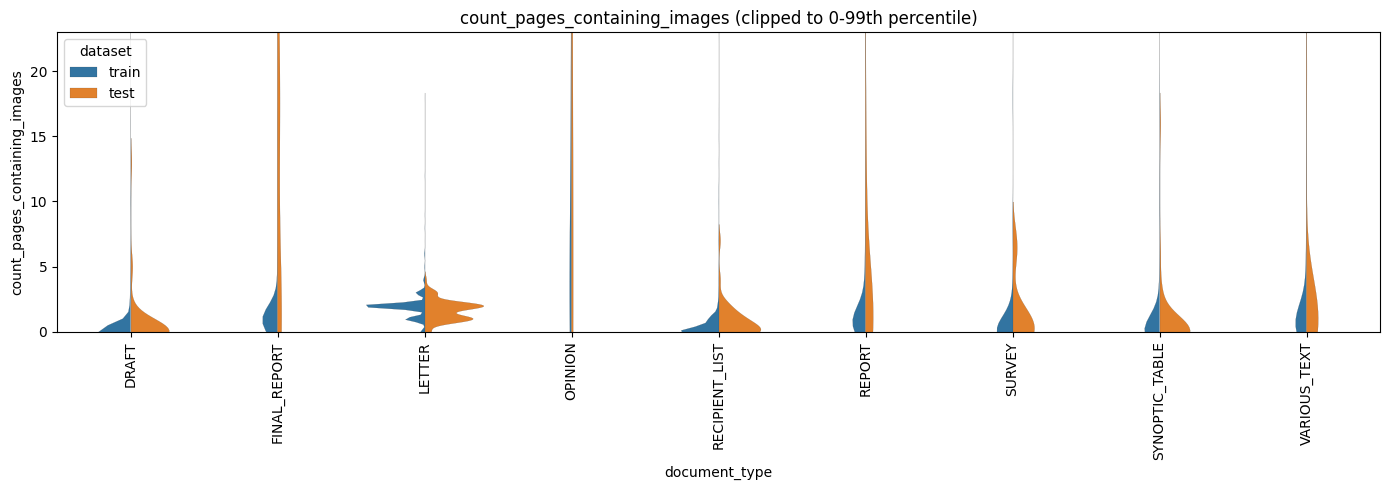

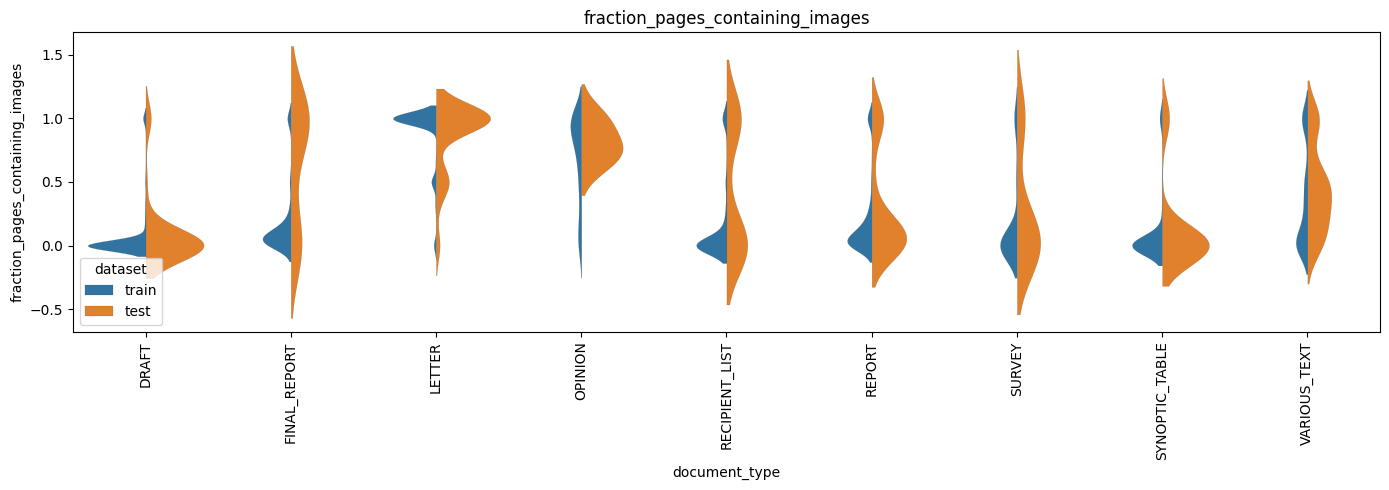

In [28]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_images")

### Time features

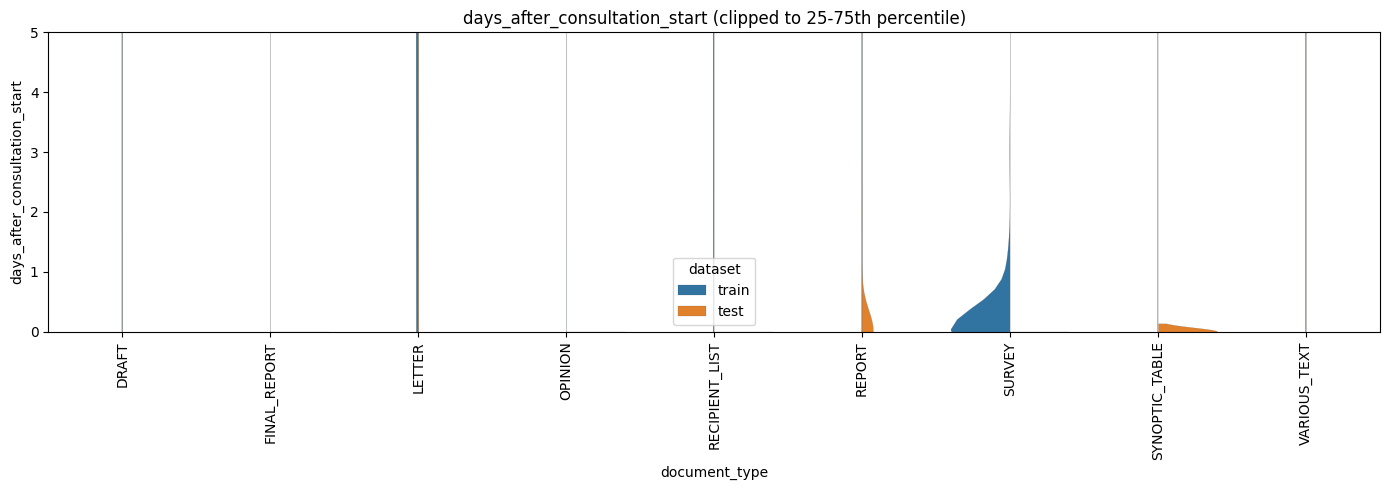

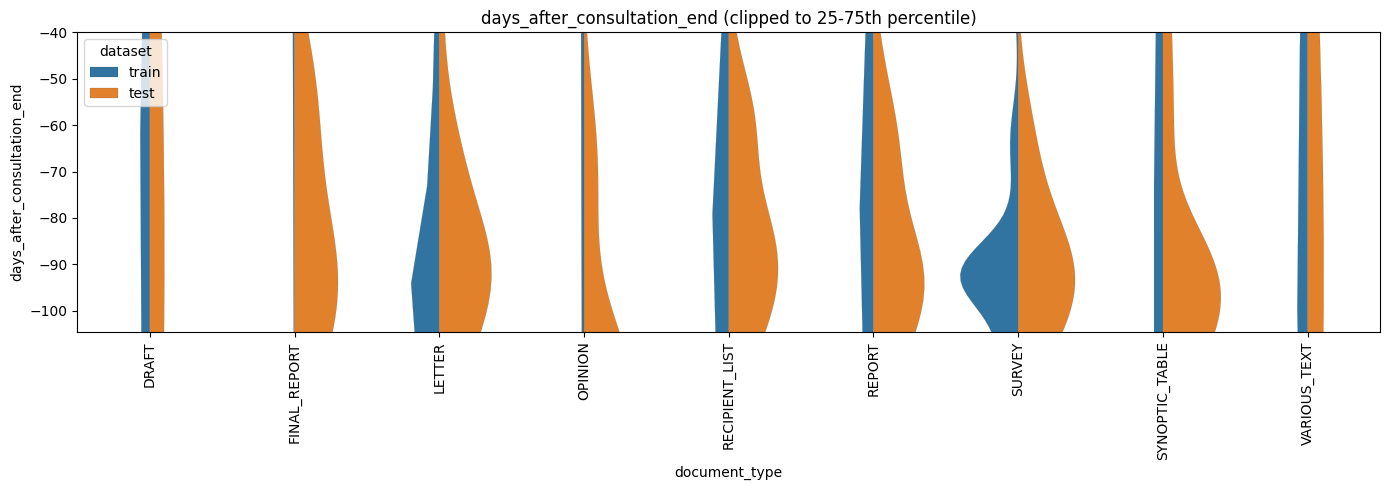

In [29]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

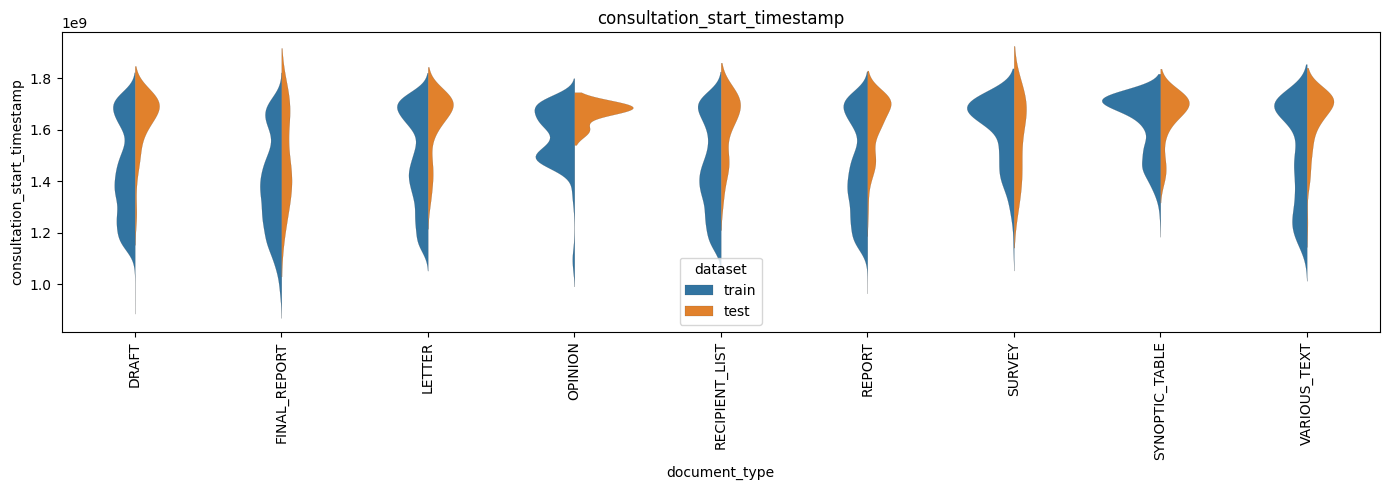

In [30]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [31]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train)
X_test, y_test = demokratis_ml.models.document_types.model.create_matrices(df_input_test)

print("train", X_train.shape)
print("test", X_test.shape)

train (14209, 3084)
test (414, 3084)


In [32]:
classifier = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    random_state=RANDOM_STATE,
)
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=40,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3083, None)),
                                                 ('categorical_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3083, None, None))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2718))])

In [33]:
def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=CV_FOLDS,
        shuffle=True,
        random_state=RANDOM_STATE,
    ),
    scoring=scoring,
)
scores_docs

{'fit_time': array([6.41238332, 6.79494762, 6.34320474, 6.04653406, 6.46993089]),
 'score_time': array([0.18014288, 0.1923511 , 0.19691801, 0.16159391, 0.20509601]),
 'test_precision': array([0.94638021, 0.95332905, 0.93577064, 0.94595794, 0.93825036]),
 'test_recall': array([0.94651654, 0.95355384, 0.93771992, 0.94616467, 0.93980993]),
 'test_f1': array([0.94431901, 0.95211143, 0.93407296, 0.94363227, 0.93725229]),
 'test_pca_explained_variance': array([0.51296765, 0.51199979, 0.51303089, 0.51367044, 0.51312023]),
 'test_accuracy': array([0.94651654, 0.95355384, 0.93771992, 0.94616467, 0.93980993]),
 'test_top_k_accuracy': array([0.98486981, 0.98662913, 0.97923997, 0.98627727, 0.98099261])}

## CV evaluation

In [34]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9448,
 'cv_f1': 0.9423,
 'cv_pca_explained_variance': 0.513,
 'cv_precision': 0.9439,
 'cv_recall': 0.9448,
 'cv_top_k_accuracy': 0.9836}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [35]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [36]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/06/06 10:49:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/06 10:49:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.92      0.95      0.93       581
  FINAL_REPORT       0.96      0.95      0.96       345
        LETTER       0.98      1.00      0.99       610
       OPINION       1.00      0.93      0.96       161
RECIPIENT_LIST       1.00      1.00      1.00       404
        REPORT       0.88      0.95      0.92       479
        SURVEY       0.96      0.82      0.89        33
SYNOPTIC_TABLE       0.91      0.87      0.89       100
  VARIOUS_TEXT       0.86      0.55      0.67       129

      accuracy                           0.94      2842
     macro avg       0.94      0.89      0.91      2842
  weighted avg       0.94      0.94      0.94      2842



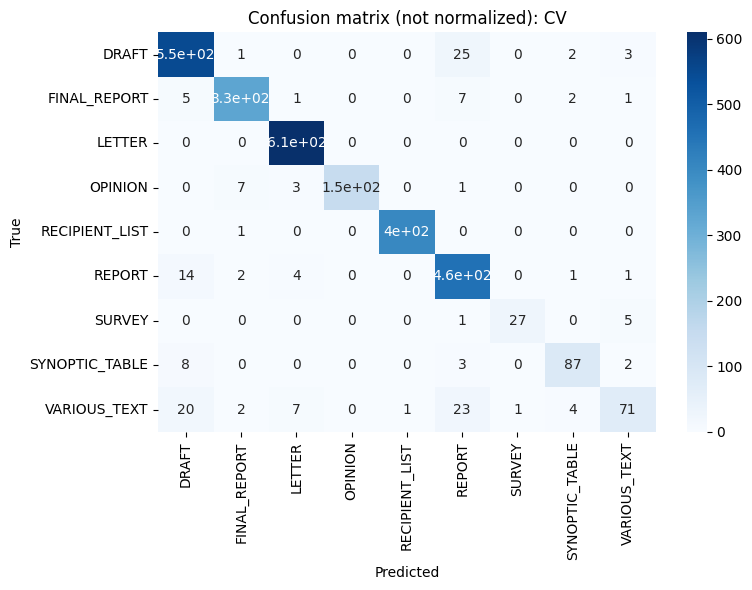

In [37]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Evaluation on the test set

2025/06/06 10:49:13 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/06 10:49:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.94      0.87      0.90        53
  FINAL_REPORT       0.80      0.27      0.40        15
        LETTER       0.95      1.00      0.98        82
       OPINION       1.00      0.40      0.57         5
RECIPIENT_LIST       1.00      1.00      1.00        41
        REPORT       0.77      0.97      0.86        98
        SURVEY       1.00      0.83      0.91        12
SYNOPTIC_TABLE       0.88      0.98      0.93        46
  VARIOUS_TEXT       0.89      0.66      0.76        62

      accuracy                           0.88       414
     macro avg       0.91      0.78      0.81       414
  weighted avg       0.89      0.88      0.87       414



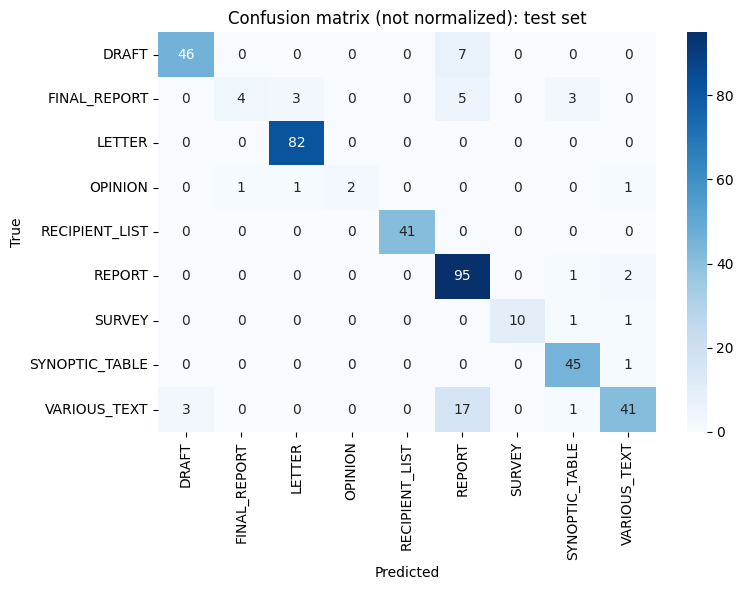

{'test_accuracy': 0.8841,
 'test_f1': 0.875,
 'test_precision': 0.891,
 'test_recall': 0.8841,
 'test_top_k_accuracy': 0.9589}


In [38]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
    )
    classifier_test.fit(X_train, y_train)
    y_test_predicted = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        y_test,
        y_test_predicted,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(y_test, y_test_predicted, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        y_test,
        y_test_predicted,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(y_test, y_test_predicted),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test, classifier_test.predict_proba(X_test)),
    )

### Feature importance

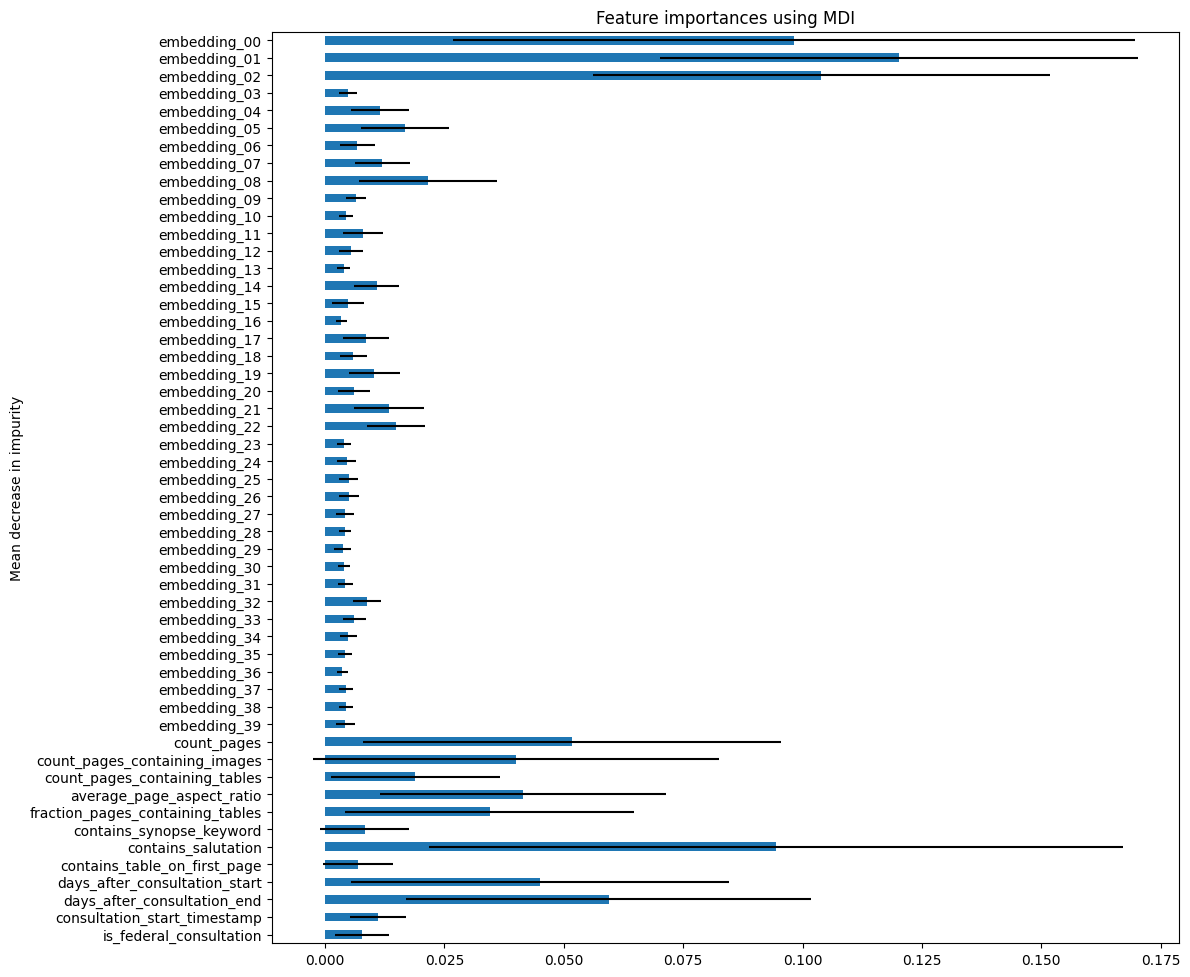

In [39]:
forest = classifier_test.named_steps["randomforestclassifier"]
pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
assert pca is not None

forest_importances = pd.Series(
    forest.feature_importances_,
    index=(
        [f"embedding_{i:02d}" for i in range(pca.n_components)]
        + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
        + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
    ),
)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
forest_importances.plot.barh(xerr=std, ax=ax)
ax.invert_yaxis()  # start with embeddings at the top
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [40]:
df_eval = df_input_test.copy()
df_eval["document_type_predicted"] = y_test_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

        LETTER       1.00      1.00      1.00         9
RECIPIENT_LIST       1.00      1.00      1.00         8
        REPORT       0.83      1.00      0.91        10
        SURVEY       1.00      0.88      0.93         8
SYNOPTIC_TABLE       0.80      1.00      0.89         4
  VARIOUS_TEXT       1.00      0.50      0.67         4

      accuracy                           0.93        43
     macro avg       0.94      0.90      0.90        43
  weighted avg       0.94      0.93      0.93        43


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      1.00      1.00         3
        LETTER       1.00      1.00      1.00         1
        REPORT  

## Comparison: rule-based model

In [41]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.24% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.42% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.93% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.24% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document_ti

                precision    recall  f1-score   support

         DRAFT       0.64      1.00      0.78        43
  FINAL_REPORT       1.00      0.83      0.91         6
        LETTER       1.00      1.00      1.00        81
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      1.00      1.00        37
        REPORT       0.97      0.84      0.90        85
        SURVEY       1.00      0.83      0.91        12
SYNOPTIC_TABLE       0.97      0.85      0.91        41
  VARIOUS_TEXT       0.96      0.85      0.90        26

      accuracy                           0.92       332
     macro avg       0.94      0.80      0.81       332
  weighted avg       0.94      0.92      0.92       332



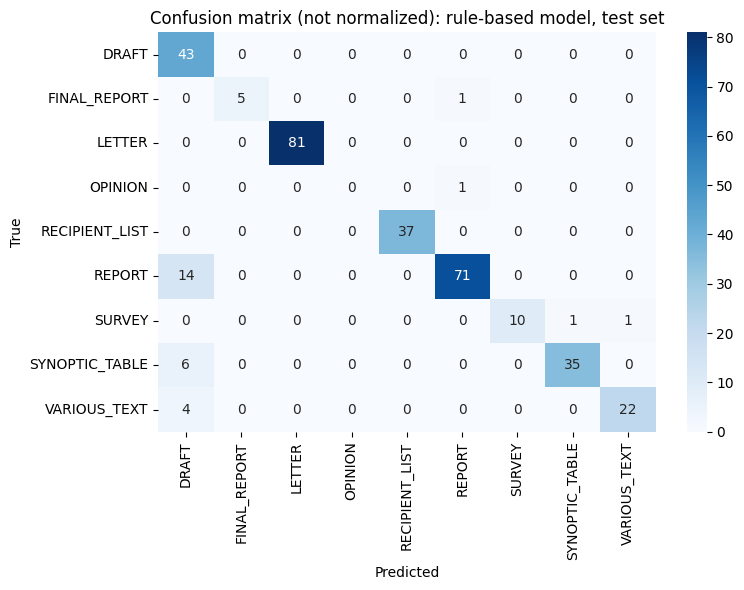

In [42]:
_y_true = y_test[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title="rule-based model, test set",
    # normalize="true",
)

## Display all test samples & predictions

In [43]:
df_display = df_input_test.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f'color: {"green" if row[col] == row["document_type"] else "red"}'
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
46823,47813,zh,vnl,doc,Auswertung VL-Antworten BesV,FINAL_REPORT,nan,SYNOPTIC_TABLE
45260,46004,ur,vnl,doc,Bericht und Vernehmlassungsvorlage,REPORT,REPORT,REPORT
38683,38712,ag,vnl,doc,Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
46023,47004,zg,vnl,doc,Synopse Gesetz PH Zug,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
47608,48626,zh,vnl,doc,Regierungsratsbeschluss 1472024,VARIOUS_TEXT,nan,VARIOUS_TEXT
39072,39104,ag,vnl,doc,Synopse der Änderung mit Bemerkungsspalte,SURVEY,SYNOPTIC_TABLE,SYNOPTIC_TABLE
42519,43223,lu,vnl,doc,Vernehmlassungsentwurf,DRAFT,DRAFT,DRAFT
39727,39897,ar,vnl,doc,Liste der Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
52271,54104,zh,vnl,doc,Erläuternder Bericht,REPORT,REPORT,REPORT
47230,48225,zh,vnl,doc,5510 Gesundheitsgesetz,DRAFT,nan,REPORT


***

# End run

In [44]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [45]:
mlflow.end_run()

🏃 View run amusing-flea-555 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/99c9ed9e7f9f4298ae76d8c48841f2f8
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
